In [1]:
# control random processes
import torch
torch.manual_seed(1)
import numpy as np
np.random.seed(1)

from network import NeuralNetwork

In [5]:
import baseline

1079.66
[[ 16   6]
 [ 32 150]
 [ 64 727]
 [128 982]
 [256 134]
 [512   1]]


In [5]:
network = NeuralNetwork()
network.train(duration=2, game_penalty_type='scores', cutoff=20, batch_size=200, forget_after=40)

Final average scores: 85.72


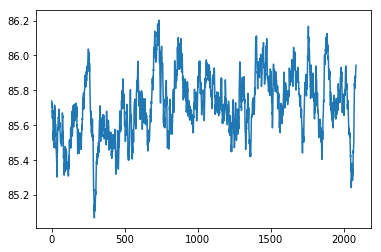

In [6]:
import matplotlib.pyplot as plt

plt.plot(network.model.evaluation)
plt.show()

In [12]:
game_rank_values = np.array([12,15,18])

In [13]:
maxes = np.repeat(game_rank_values.max(), game_rank_values.shape)
maxes[game_rank_values<=np.median(game_rank_values)] = game_rank_values.min()
maxes = np.absolute(maxes-np.median(game_rank_values))
final_penalties = np.nan_to_num((game_rank_values-np.median(game_rank_values))/maxes)

In [14]:
final_penalties

array([-1.,  0.,  1.])

In [18]:
mask = final_penalties<0
mask = torch.from_numpy(mask).nonzero().flatten()

In [19]:
mask

tensor([0])

In [3]:
for move_penalty in [None,'nonzero','linear_move_num','exponential_move_num']:
    print(move_penalty)
    network = NeuralNetwork()
    network.train(duration=.5, move_penalty_type=move_penalty)

None
Final average scores: 1100.84
nonzero
Final average scores: 1101.13
linear_move_num
Final average scores: 1108.38
exponential_move_num
Final average scores: 1112.41


In [ ]:
for game_penalty in ['scores','max','log2_max','tile_sums']:
    print(game_penalty)
    network = NeuralNetwork()
    network.train(duration=.5, move_penalty_type='exponential_move_num',
                 game_penalty_type=game_penalty)
    
'''
scores
Final average scores: 1092.2
max
Final average scores: 1090.03
log2_max
Final average scores: 1100.5
tile_sums
Final average scores: 1094.5
'''

In [ ]:
for forget_interval in [10,50,110]:
    print(forget_interval)
    network = NeuralNetwork()
    network.train(duration=1, move_penalty_type='exponential_move_num',
                  game_penalty_type='scores', forget_after=forget_interval)
    
'''
10
Final average scores: 1102.82
50
Final average scores: 1086.96
110
Final average scores: 1093.88
'''

In [ ]:
for game_penalty in ['scores','max','log2_max','tile_sums']:
    for learning_rate in [.001, .01, .05]:
        print(game_penalty, learning_rate)
        network = NeuralNetwork()
        network.train(duration=.5, move_penalty_type='exponential_move_num',
                 game_penalty_type=game_penalty, lr=learning_rate)
        
'''
scores 0.001
Final average scores: 1087.01
scores 0.01
Final average scores: 1111.22
scores 0.05
Final average scores: 1084.33
max 0.001
Final average scores: 1075.7
max 0.01
'''

In [4]:
for game_penalty in ['scores','tile_sums']:
    network = NeuralNetwork()
    network.train(duration=.5, move_penalty_type='exponential_move_num',
                     game_penalty_type=game_penalty, lr=0.01, batch_size=10)

Final average scores: 1080.51
Final average scores: 1097.18


In [5]:
for game_penalty in ['scores','tile_sums']:
    print(game_penalty)
    network = NeuralNetwork()
    network.train(duration=2, move_penalty_type='exponential_move_num',
                     game_penalty_type=game_penalty, lr=0.01, batch_size=10)

scores
Final average scores: 1092.23
tile_sums
Final average scores: 1111.33


In [21]:
network = NeuralNetwork()
network.train(duration=1, move_penalty_type='exponential_move_num',
             game_penalty_type='tile_sums', lr=0.01, batch_size=100, forget_after=100)

KeyboardInterrupt: 

In [ ]:
for move_penalty in ['nonzero','linear_move_num']:
    for i in range(4):
        print(move_penalty, i)
        network = NeuralNetwork()
        network.train(duration=.5, move_penalty_type=move_penalty,
                 game_penalty_type='scores', lr=0.01)
        
'''
nonzero 0
1089.8649333333335
nonzero 1
1092.2149333333334
nonzero 2
1097.7331333333332
nonzero 3
1106.5646
linear_move_num 0
1076.3795333333333
linear_move_num 1
1080.4103333333333
linear_move_num 2
1083.9425999999999
linear_move_num 3
1103.7242666666666
'''